<a href="https://colab.research.google.com/github/aaryan-gulia/UCLBnF-Algorithmic-Research/blob/main/crypto_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import numpy as np
from plotly import graph_objects as go

In [2]:
def kraken_api_data(symbol, timeframe, extract):

  # Fetch OHLCV data from Kraken
  url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'

  # Make the API request
  response = requests.get(url)
  data = response.json()

  # Extract OHLCV data
  ohlc_data = data['result'][extract]

  # Convert the data to a DataFrame
  columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'wavg price', 'count']
  df = pd.DataFrame(ohlc_data, columns=columns)

  # Convert Unix timestamp to datetime format
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

  # Convert 'open', 'high', 'low', 'close', 'volume', 'wavg_price' to numeric type
  string_columns = ['open', 'high', 'low', 'close', 'volume', 'wavg price']
  df[string_columns] = df[string_columns].apply(pd.to_numeric, errors='coerce')
  df.set_index('timestamp', inplace = True)

  return df

In [3]:
eth_df = kraken_api_data("ETHUSD","1440","XETHZUSD")
eth_df.head()

,open,high,low,close,volume,wavg price,count
timestamp,,,,,,,
2021-12-10,4106.13,4238.00,3889.00,3901.90,4053.04,47555.087612,40000
2021-12-11,3901.90,4097.91,3833.36,4088.80,3998.38,30223.126620,29620
2021-12-12,4090.65,4176.99,3990.00,4133.54,4083.39,25941.880658,20793
2021-12-13,4133.08,4145.54,3665.41,3783.38,3840.96,50157.673719,41647
2021-12-14,3784.12,3881.71,3689.00,3861.96,3796.30,46526.814884,31846


In [4]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [5]:
statistic = adfuller(eth_df['close'])

In [6]:
eth_t_statistic = statistic[0]
eth_p_value = statistic[1]
eth_critical_values = statistic[4]

print(f"ADF Test Statistic: {eth_t_statistic: 0.4f}")
print(f"P-value of ADF test: {eth_p_value: 0.4f}")
print(f"Critical values:")
print(f"1%: {eth_critical_values['1%']: 0.4f} \n5%: {eth_critical_values['5%']: 0.4f} \n10%: {eth_critical_values['10%']: 0.4f}")

ADF Test Statistic: -2.9036
P-value of ADF test:  0.0449
Critical values:
1%: -3.4395 
5%: -2.8656 
10%: -2.5689


In [7]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

In [8]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [9]:
eth_hurst_exp = hurst(list(eth_df['close']))
print(f"Hurst Exponent: {eth_hurst_exp}")

Hurst Exponent: 0.4602367100338338


In [10]:
btc_df = kraken_api_data("BTCUSD","1440","XXBTZUSD")
btc_df.head()

,open,high,low,close,volume,wavg price,count
timestamp,,,,,,,
2021-12-10,47576.4,50114.2,46888.8,47218.3,48261.3,3323.541756,34264
2021-12-11,47173.9,49500.0,46800.0,49367.2,48521.7,2068.416771,23586
2021-12-12,49406.0,50788.4,48697.8,50113.2,49746.9,2022.363982,22650
2021-12-13,50098.8,50219.8,45759.0,46732.2,47604.1,4915.423073,41085
2021-12-14,46732.2,48690.0,46313.7,48399.2,47204.2,3830.824064,35772


In [11]:
statistic = adfuller(btc_df['close'])

btc_t_statistic = statistic[0]
btc_p_value = statistic[1]
btc_critical_values = statistic[4]

print(f"ADF Test Statistic: {btc_t_statistic: 0.4f}")
print(f"P-value of ADF test: {btc_p_value: 0.4f}")
print(f"Critical values:")
print(f"1%: {btc_critical_values['1%']: 0.4f} \n5%: {btc_critical_values['5%']: 0.4f} \n10%: {btc_critical_values['10%']: 0.4f}")

ADF Test Statistic: -2.0432
P-value of ADF test:  0.2680
Critical values:
1%: -3.4396 
5%: -2.8656 
10%: -2.5689


In [12]:
btc_hurst_exp = hurst(list(btc_df['close']))
print(f"Hurst Exponent: {btc_hurst_exp}")

Hurst Exponent: 0.48683168450255243


In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = eth_df["close"], y = btc_df["close"], mode='markers'))

fig.update_layout(title='BTC vs ETH scatter plot',
                     xaxis_title = "ETH prices",
                     yaxis_title= "BTC prices")

fig.show()

In [14]:
def create_residuals(ts_1,ts_2):
    """
    Calculate the OLS and create the beta hedge ratio and residuals for the two
    time series. We use the statsmodel.api libary's OLS model.

    Parameters
    ----------
    ts_1 and ts_2 : two time series lists

    Returns
    -------
    price_df : list of residuals
    beta_hr : beta hedge ratio
    """
    # Create an Ordinary Least Squares regression model
    Y = ts_1
    x = ts_2
    #x = sm.add_constant(x)
    model = sm.OLS(Y, x)
    res = model.fit()

    # Beta hedge ratio (coefficent from OLS)
    beta_hr = res.params[0]
    print(f'Beta Hedge Ratio: {beta_hr}')

    # Residuals
    price_df = pd.DataFrame(res.resid, columns = ["spread"])
    return price_df, beta_hr

In [15]:
eth_btc_resid, beta_hr = create_residuals(eth_df['close'], btc_df['close'])
eth_btc_resid.head()

Beta Hedge Ratio: 0.06847849307113296


,spread
timestamp,
2021-12-10,668.461971
2021-12-11,708.208537
2021-12-12,701.863581
2021-12-13,583.229366
2021-12-14,547.655718


In [16]:
statistic = adfuller(eth_btc_resid['spread'])

btc_t_statistic = statistic[0]
btc_p_value = statistic[1]
btc_critical_values = statistic[4]

print(f"ADF Test Statistic: {btc_t_statistic: 0.4f}")
print(f"P-value of ADF test: {btc_p_value: 0.4f}")
print(f"Critical values:")
print(f"1%: {btc_critical_values['1%']: 0.4f} \n5%: {btc_critical_values['5%']: 0.4f} \n10%: {btc_critical_values['10%']: 0.4f}")

ADF Test Statistic: -2.4752
P-value of ADF test:  0.1216
Critical values:
1%: -3.4395 
5%: -2.8656 
10%: -2.5689


In [17]:
btc_hurst_exp = hurst(list(eth_btc_resid['spread']))
print(f"Hurst Exponent: {btc_hurst_exp: 0.4f}")

Hurst Exponent:  0.3935


In [18]:
!pip install arch

In [19]:
from arch.unitroot import VarianceRatio

In [20]:
VarianceRatio(eth_btc_resid['spread'])

Test Statistic,-0.260
P-value,0.795
Lags,2


In [21]:
import plotly.graph_objects as go

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = eth_btc_resid.index.values, y = eth_btc_resid["spread"]))

fig.update_layout(title='BTC/ETH beta hedged Spread',
                     xaxis_title='Date',
                     yaxis_title='Spread')

fig.show()

In [23]:
#Run OLS regression on spread series and lagged version of itself

def half_life(ts):
  """
  This function calculates the halflife of the mean reverion for a given time series

  Parameters
    ----------
    ts : a time series list

    Returns
    -------
    half_life : the halflife float

  """
  # Lag the residuals
  lagged_residuals = ts.shift(1).dropna()

  diff_residuals_lagged = ts.diff().dropna()

  # Add a constant to the lagged residuals
  lagged_residuals_with_const = sm.add_constant(lagged_residuals)

  # Fit an Ordinary Least Squares (OLS) model
  model = sm.OLS(diff_residuals_lagged, lagged_residuals_with_const)
  results = model.fit()

  # Get the speed of mean reversion (theta) from the model
  theta = -results.params[1]

  # Calculate half-life
  half_life = np.log(2) / theta

  return half_life

In [24]:
halflife = half_life(eth_btc_resid["spread"])
print(f"Halflife = {halflife}")

Halflife = 48.472579291394986


In [25]:
from statsmodels.tsa.vector_ar import vecm

In [26]:
ethbtc_johres = vecm.coint_johansen((pd.concat((eth_df.rename(columns={"close": "eth"})["eth"],
                                                  btc_df.rename(columns={"close": "btc"})["btc"]),
                                                 axis = 1)),
                                      det_order=0,
                                      k_ar_diff=1)

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"]).rename(index = {"0": "r <= 0", "1" : "r <= 1"})
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

joh_output(ethbtc_johres)

   max_eig_stat  trace_stat
0     13.517994   14.002961
1      0.484967    0.484967 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [27]:
coint_vec = ethbtc_johres.evec
coint_val = ethbtc_johres.eig

print(f"Eigen Value ({coint_val[0]}) : Eigen Vector ({coint_vec[0,0]},{coint_vec[1,0]}")
print(f"Eigen Value ({coint_val[1]}) : Eigen Vector ({coint_vec[0,1]},{coint_vec[1,1]}")

Eigen Value (0.018651162972377486) : Eigen Vector (0.003362321110213881,-0.00017196507290334178
Eigen Value (0.0006752134583944622) : Eigen Vector (-0.0030163162406139283,0.00031134675362157915


In [28]:
coint_weights = coint_vec[:,0]
norm_weights = coint_weights/sum(abs(coint_weights))
print(f"Normalised Weights for the cointegrated portfolio: ")
print(f"{norm_weights}")

Normalised Weights for the cointegrated portfolio: 
[ 0.95134376 -0.04865624]


In [29]:
coint_prices = pd.DataFrame({"eth" : eth_df["close"], "btc" : btc_df["close"]}).dot(norm_weights)
coint_prices = pd.DataFrame({"spread" : coint_prices})
coint_prices.head()

,spread
timestamp,
2021-12-10,1414.583336
2021-12-11,1487.832093
2021-12-12,1494.097658
2021-12-13,1325.481871
2021-12-14,1319.128513


In [30]:
halflife = half_life(coint_prices['spread'])
print(f"Halflife = {halflife}")

Halflife = 43.59656587171956


<Axes: xlabel='timestamp'>

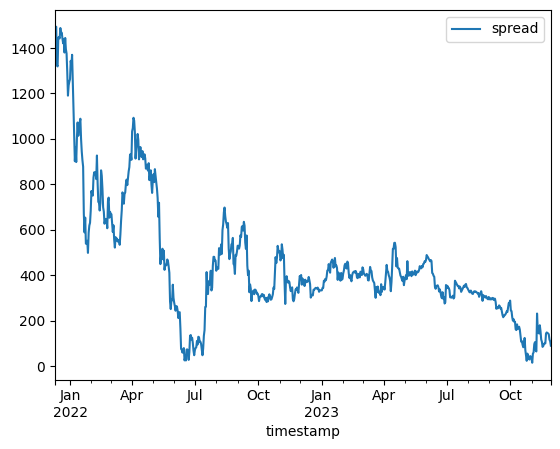

In [31]:
coint_prices.plot()

In [48]:
# Strategy
strategy_df = pd.DataFrame({"eth" : eth_df['close'], "btc" : btc_df['close']})
strategy_df['coint_portfolio'] = coint_prices
strategy_df['sma_halflife'] = strategy_df['coint_portfolio'].rolling(window=round(halflife)).mean()
strategy_df.dropna(inplace = True)
strategy_df['position'] = -(strategy_df['coint_portfolio'] - strategy_df['sma_halflife'])/(strategy_df['coint_portfolio'] - strategy_df['sma_halflife']).rolling(window=round(halflife)).std()
strategy_df.dropna(inplace = True)
strategy_df.head()

,eth,btc,coint_portfolio,sma_halflife,position
timestamp,,,,,
2022-03-06,2550.39,38416.3,557.104944,693.207926,0.693991
2022-03-07,2492.62,38024.0,521.233657,691.683736,0.919933
2022-03-08,2578.19,38752.6,567.189207,689.724868,0.689392
2022-03-09,2728.16,41965.3,553.544333,690.068908,0.833247
2022-03-10,2606.81,39435.8,561.174723,690.572637,0.866094


In [49]:
strategy_df['position'] = strategy_df['position'].shift(1)
strategy_df["coint_daily_return"] = strategy_df['coint_portfolio'].pct_change()
strategy_df["eth_daily_return"] = strategy_df['eth'].pct_change()
strategy_df["btc_daily_return"] = strategy_df['btc'].pct_change()
strategy_df.dropna(inplace = True)
strategy_df["strat_daily_return"] = strategy_df["coint_daily_return"] * strategy_df['position']
strategy_df['coint_cumulative_return'] = (1 + strategy_df['coint_daily_return']).cumprod() - 1
strategy_df['eth_cumulative_return'] = (1 + strategy_df['eth_daily_return']).cumprod() - 1
strategy_df['btc_cumulative_return'] = (1 + strategy_df['btc_daily_return']).cumprod() - 1
strategy_df['strat_cumulative_return'] = (1 + strategy_df['strat_daily_return']).cumprod() - 1
strategy_df.head()

,eth,btc,coint_portfolio,sma_halflife,position,coint_daily_return,eth_daily_return,btc_daily_return,strat_daily_return,coint_cumulative_return,eth_cumulative_return,btc_cumulative_return,strat_cumulative_return
timestamp,,,,,,,,,,,,,
2022-03-07,2492.62,38024.0,521.233657,691.683736,0.693991,-0.064389,-0.022651,-0.010212,-0.044685,-0.064389,-0.022651,-0.010212,-0.044685
2022-03-08,2578.19,38752.6,567.189207,689.724868,0.919933,0.088167,0.034329,0.019162,0.081108,0.018101,0.010900,0.008754,0.032798
2022-03-09,2728.16,41965.3,553.544333,690.068908,0.689392,-0.024057,0.058169,0.082903,-0.016585,-0.006391,0.069703,0.092383,0.015669
2022-03-10,2606.81,39435.8,561.174723,690.572637,0.833247,0.013785,-0.044481,-0.060276,0.011486,0.007305,0.022122,0.026538,0.027335
2022-03-11,2557.05,38732.1,548.075253,690.500958,0.866094,-0.023343,-0.019088,-0.017844,-0.020217,-0.016208,0.002611,0.008220,0.006566


In [50]:
strategy_df.describe()

,eth,btc,coint_portfolio,sma_halflife,position,coint_daily_return,eth_daily_return,btc_daily_return,strat_daily_return,coint_cumulative_return,eth_cumulative_return,btc_cumulative_return,strat_cumulative_return
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,1763.881137,26541.020537,386.671079,406.541918,0.470215,0.013760,0.000297,0.000375,0.044504,-0.305928,-0.308388,-0.309121,2.775876
std,483.244254,7030.358121,198.780256,176.180459,1.544352,0.231477,0.036212,0.028172,0.716370,0.356809,0.189479,0.183005,3.407707
min,994.600000,15760.000000,14.128894,95.947062,-3.107823,-0.689432,-0.177042,-0.154669,-2.554414,-0.974639,-0.610020,-0.589757,-1.384124
25%,1521.610000,20793.200000,298.522785,332.162628,-0.552068,-0.040089,-0.014305,-0.010683,-0.028738,-0.464153,-0.403381,-0.458740,0.199916
50%,1680.620000,26417.400000,365.251571,383.643304,0.290789,-0.004748,-0.000439,-0.000644,0.000724,-0.344376,-0.341034,-0.312339,1.399743
75%,1880.460000,29797.900000,448.498687,423.330844,1.331885,0.034152,0.015386,0.012979,0.031777,-0.194948,-0.262677,-0.224342,5.542435
max,3523.190000,47440.200000,1092.976784,905.014435,4.910553,2.844727,0.182807,0.106753,8.942233,0.961887,0.381432,0.234898,10.684353


In [51]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.eth_cumulative_return, name = "ETH Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.btc_cumulative_return, name = "BTC Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.coint_cumulative_return, name = "Beta-Hedged Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.strat_cumulative_return, name = "Strategy Cumulative Return"))

fig.update_layout(title='Cumulative Returns from ETH, BTC, Beta-Hedged Pair Portfolio, and Strategy',
                     xaxis_title='Date',
                     yaxis_title='Cumulative Returns')

fig.show()